In [1]:
from PIL import Image
from sympy.polys.polyconfig import query
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

from week06.RAG101_02_RAG检索TFIDF import query_idx

model = ChineseCLIPModel.from_pretrained('../models/AI-ModelScope/chinese-clip-vit-base-patch16')
processor = ChineseCLIPProcessor.from_pretrained('../models/AI-ModelScope/chinese-clip-vit-base-patch16')

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
import glob, json, os
import tqdm
from PIL import Image
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./img/*.png')
img_paths.sort()

img_captions = open('./img/captions.txt', 'r').readlines()
img_captions = [x.strip() for x in img_captions]

img_paths, img_captions

(['./img/1.png', './img/2.png', './img/3.png'],
 ['一位戴眼镜、穿酒红色高领毛衣的男性坐在桌前，背景是书架和一幅画，看起来像是在进行讲解或录制视频。',
  '一位穿着米色风衣、围着格子围巾的女性站在湖边，背景是绿树和水面，照片发布于社交平台，配文“秋天里的散文诗”，带有多个标签如#秋天、#故事感等',
  '一张文字截图，内容为作业要求：“作业2：使用云端qwen-vl模型，完成带文字截图的图，文本的解析转换为文本。”'])

In [ ]:
Image.open(img_paths[0])

In [5]:
img_image_feat = []
batch_size = 20
for idx in tqdm.notebook.tqdm(range(len(img_captions) // batch_size + 1)):
    imgs = [Image.open(path) for path in img_paths[idx * batch_size: (idx + 1) * batch_size]]

    if( len(imgs)) == 0:
        break
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)
    break

img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
img_image_feat.shape

(3, 512)

In [7]:
img_texts_feat = []
batch_size = 20
for idx in tqdm.notebook.tqdm(range(len(img_captions) // batch_size + 1)):
    texts = [text for text in img_captions[idx * batch_size: (idx + 1) * batch_size]]

    if( len(texts)) == 0:
        break
    inputs = processor(text = texts, return_tensors="pt", padding=True)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    break

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
img_texts_feat.shape

### 相似度计算

输入文本:  一位穿着米色风衣、围着格子围巾的女性站在湖边，背景是绿树和水面，照片发布于社交平台，配文“秋天里的散文诗”，带有多个标签如#秋天、#故事感等


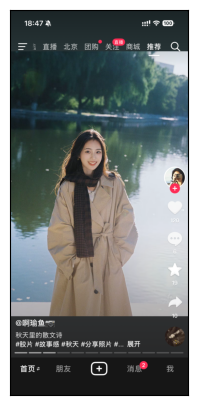

In [19]:
query_idx = 1

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T)
sim_idx = sim_result.argsort()[::-1]

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])
print('输入文本: ', img_captions[query_idx])

### 文本标签编码

In [23]:
import jieba

img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))

In [24]:
img_captions2words[:10]

['戴眼镜', '文字', '内容', '毛衣', '绿树', '讲解', '标签', '作业', '格子', '米色']

In [25]:
img_texts_feat = []

for idx in tqdm.tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break

    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)

img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

/var/folders/63/cpfykmw13hg5ss1nyn577lrh0000gn/T/ipykernel_45836/1661230247.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm.tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
query_idx = 2
sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1]

文本识别结果:  ['qwen', '作业', '截图', '配文', '解析', '感等', '转换', '发布', '内容', '进行']


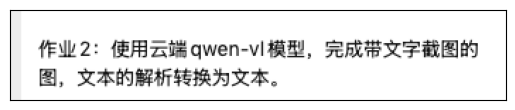

In [31]:
plt.imshow(Image.open(img_paths[query_idx]))
plt.xticks([]); plt.yticks([])

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx[:10]])